# Surface concentrations

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
from itertools import compress
import datetime as dt
from datetime import date
import xarray as xr

%matplotlib inline

###### Parameters:

In [2]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax - imin
jsize = jmax - jmin

land_color = '#8b7765'

# model results:
year = 2002

# spinup0_old  = '/data/brogalla/run_storage/Mn-reference-202103/spin-up0-202103/'
# spinup0_old  = '/data/brogalla/run_storage/ref-spin-up0-202106/'
# spinup1_old  = '/data/brogalla/run_storage/Mn-reference-202103/spin-up1-202103/'
# spinup2_old  = '/data/brogalla/run_storage/Mn-reference-202103/spin-up2-202103/'
# spinup0_new  = '/data/brogalla/run_storage/ref-spin-up0-202106-manualsinking/'
# spinup1_new  = '/data/brogalla/run_storage/ref-spin-up1-202106/'
# spinup2_new  = '/data/brogalla/run_storage/ref-spin-up2-202106/'
spinup0_spm    = '/data/brogalla/run_storage/Mn-tuning-202107/ANHA12_spin-up0_20210722-spm/'
spinup0_nospm  = '/data/brogalla/run_storage/Mn-tuning-202107/ANHA12_spin-up0_20210722-nospm/'

In [3]:
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask     = np.array(mask.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 
lons      = np.array(mask.variables['nav_lon'])[imin:imax,jmin:jmax] 
lats      = np.array(mask.variables['nav_lat'])[imin:imax,jmin:jmax]
depth     = np.array(mask.variables['nav_lev'])

##### Functions:

In [4]:
def load_data(exp_folder):
    
    ds = xr.open_dataset(f'{exp_folder}ANHA12_EXH006_{year}_monthly.nc')
    dissolmn = ds['dissolmn'].values*1e9
    oxidismn = ds['oxidismn'].values*1e9
    
    return dissolmn, oxidismn

In [5]:
def plot_experiment(ax, variable, month=0, layer=0, vmin=0, vmax=7, cmap=cmocean.cm.dense):
    proj1 = Basemap(projection='stere',lat_0 = 77.1, lon_0 = -85, resolution='i', width=4.5e6, height=2.98e6, ax=ax)
    proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=5);
    x, y = proj1(lons, lats)
    
    var = np.ma.masked_where(tmask[layer,:,:] < 0.1, variable[month,layer,:,:])
    
    c1 = proj1.contourf(x, y, var, np.arange(vmin,vmax+1,0.25),\
                             cmap=cmap, vmin=vmin, vmax=vmax, extend='both')
    
    return c1

In [6]:
def plot_comparison(var1, var2, month=0, layer=0, ox=False):
    
    var1_plot = var1[:,0,:,:,:]
    var2_plot = var2[:,0,:,:,:]
    
    fig, ax = plt.subplots(1,3, figsize=(20,4))
    
    if ox:
        fig.suptitle(f'Oxidised Mn for month index {month}, depth layer {layer}', fontsize=14)
        # Panel A & B: 
        c1 = plot_experiment(ax[0], var1_plot, vmax=12, month=month, layer=layer)
        c2 = plot_experiment(ax[1], var2_plot, vmax=12, month=month, layer=layer)
        c3 = plot_experiment(ax[2], var2_plot-var1_plot, vmin=-4, vmax=4, cmap=cmocean.cm.balance, month=month, layer=layer)        
    else:
        fig.suptitle(f'Dissolved Mn for month index {month}, depth layer {layer}', fontsize=14)
        # Panel A & B: 
        c1 = plot_experiment(ax[0], var1_plot, vmax=12, month=month, layer=layer)
        c2 = plot_experiment(ax[1], var2_plot, vmax=12, month=month, layer=layer)
        c3 = plot_experiment(ax[2], var2_plot-var1_plot, vmin=-4, vmax=4, cmap=cmocean.cm.balance, month=month, layer=layer)
    
    ax[0].set_title('Reference exp (Mn-reference-202103)', fontsize=12)
    ax[1].set_title('Sinking fixed', fontsize=12)
    ax[2].set_title('Difference', fontsize=12)

    cbar_ax1 = fig.add_axes([0.13, 0.15, 0.02, 0.25])
    cbar_ax2 = fig.add_axes([0.41, 0.15, 0.02, 0.25])
    cbar_ax3 = fig.add_axes([0.68, 0.15, 0.02, 0.25])
    cbar1    = fig.colorbar(c1, cax=cbar_ax1, ticks=np.arange(0,14,4))
    cbar2    = fig.colorbar(c2, cax=cbar_ax2, ticks=np.arange(0,14,4))
    cbar3    = fig.colorbar(c3, cax=cbar_ax3, ticks=np.linspace(-4,4,5))

    return

In [7]:
def setup_axes(xlim=(0,6), ylim=(500,0)):
    fig, ax = plt.subplots(1,2, figsize=(8,6))
    
    ax[0].set_title('Dissolved Mn [nM]', fontsize=12)
    ax[1].set_title('Oxidised Mn [nM]', fontsize=12)
    ax[0].set_ylabel('Depth [m]', fontsize=12)

    for axis in ax.ravel():
        axis.invert_yaxis()
        axis.set_xlim(xlim)
        axis.set_ylim(ylim)
        axis.tick_params(axis='both', labelsize=12)
        axis.xaxis.tick_top()    
        axis.xaxis.set_label_position('top')
    return fig, ax

In [8]:
def add_profile(ax, dmn, omn, label='', c='#000000'):
    # Average over a region in central Canada Basin
    month=7
    i  = 608
    j  = 418
    di = 30
    dj = 30

    dmn_plot = dmn[month,0,:,i-di:i+di,j-dj:j+dj].mean(axis=(1,2))
    omn_plot = omn[month,0,:,i-di:i+di,j-dj:j+dj].mean(axis=(1,2))
    
    ax[0].plot(dmn_plot, depth, '-', color=c, linewidth=2.0)
    ax[0].plot(dmn_plot, depth, '.', color=c, markersize=15, markeredgecolor='k', label=label)

    ax[1].plot(omn_plot, depth, '-', color=c, linewidth=2.0)
    ax[1].plot(omn_plot, depth, '.', color=c, markersize=15, markeredgecolor='k', label=label)
        
    return

#### Load data:

In [9]:
dmn_spinup0_spm, omn_spinup0_spm = load_data(spinup0_spm)
dmn_spinup0_nospm, omn_spinup0_nospm = load_data(spinup0_nospm)

### Profiles:

NameError: name 'dmn_spinup0_old' is not defined

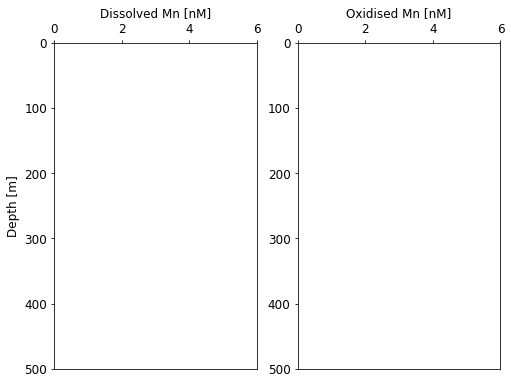

In [10]:
fig, ax = setup_axes(xlim=(0,6), ylim=(500,0))

add_profile(ax, dmn_spinup0_old, omn_spinup0_old, label='Old spinup0', c='#d9e9aa')
# add_profile(ax, dmn_spinup1_old, omn_spinup1_old, label='Old spinup1', c='#b4d455')
# add_profile(ax, dmn_spinup2_old, omn_spinup2_old, label='Old spinup2', c='#7d943b')

add_profile(ax, dmn_spinup0_new, omn_spinup0_new, label='New spinup0', c='#b2cad5')
# add_profile(ax, dmn_spinup1_new, omn_spinup1_new, label='New spinup1', c='#6696ab')
# add_profile(ax, dmn_spinup2_new, omn_spinup2_new, label='New spinup2', c='#005073')

ax[0].legend(fontsize=12, frameon=False, loc=4)

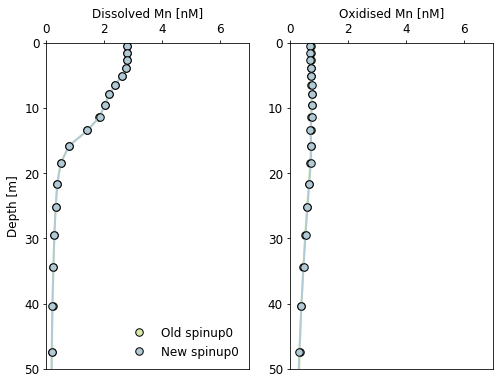

In [16]:
fig, ax = setup_axes(xlim=(0,7), ylim=(50,0))

add_profile(ax, dmn_spinup0_old, omn_spinup0_old, label='Old spinup0', c='#d9e9aa')
# add_profile(ax, dmn_spinup1_old, omn_spinup1_old, label='Old spinup1', c='#b4d455')
# add_profile(ax, dmn_spinup2_old, omn_spinup2_old, label='Old spinup2', c='#7d943b')

add_profile(ax, dmn_spinup0_new, omn_spinup0_new, label='New spinup0', c='#b2cad5')
# add_profile(ax, dmn_spinup1_new, omn_spinup1_new, label='New spinup1', c='#6696ab')
# add_profile(ax, dmn_spinup2_new, omn_spinup2_new, label='New spinup2', c='#005073')

ax[0].legend(fontsize=12, frameon=False, loc=4)

Upper 50 m of the water column barely changes between spin up periods compared to previous changes. That makes sense since the time scale of removal is more rapid, so the surface equilibrates more quickly. The deep changes more between spinup periods than before since it'll take a few years for stuff to sink from the surface to the deep. 

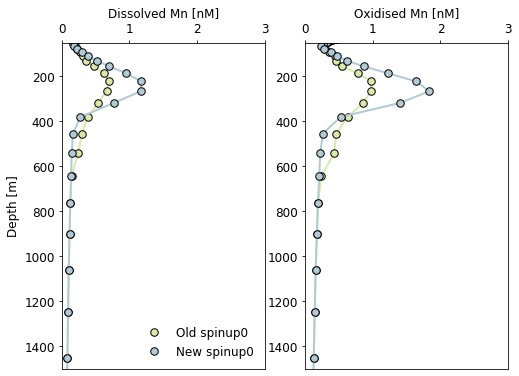

In [17]:
fig, ax = setup_axes(xlim=(0,3), ylim=(1500,50))

add_profile(ax, dmn_spinup0_old, omn_spinup0_old, label='Old spinup0', c='#d9e9aa')
# add_profile(ax, dmn_spinup1_old, omn_spinup1_old, label='Old spinup1', c='#b4d455')
# add_profile(ax, dmn_spinup2_old, omn_spinup2_old, label='Old spinup2', c='#7d943b')

add_profile(ax, dmn_spinup0_new, omn_spinup0_new, label='New spinup0', c='#b2cad5')
# add_profile(ax, dmn_spinup1_new, omn_spinup1_new, label='New spinup1', c='#6696ab')
# add_profile(ax, dmn_spinup2_new, omn_spinup2_new, label='New spinup2', c='#005073')

ax[0].legend(fontsize=12, frameon=False, loc=4)

### dissolved Mn concentrations:

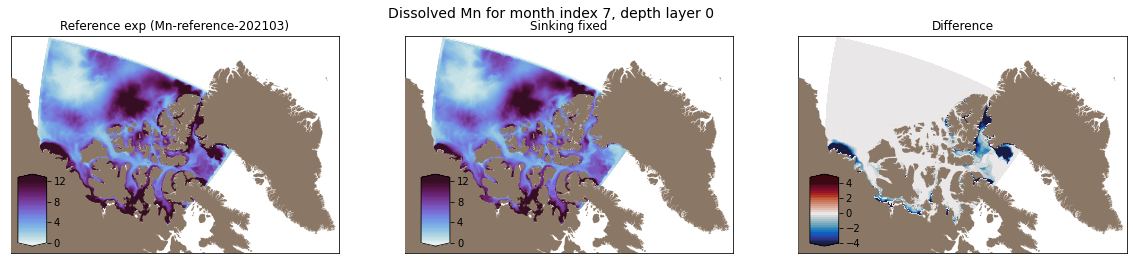

In [10]:
plot_comparison(dmn_spinup0_spm, dmn_spinup0_nospm, month=7,layer=0)

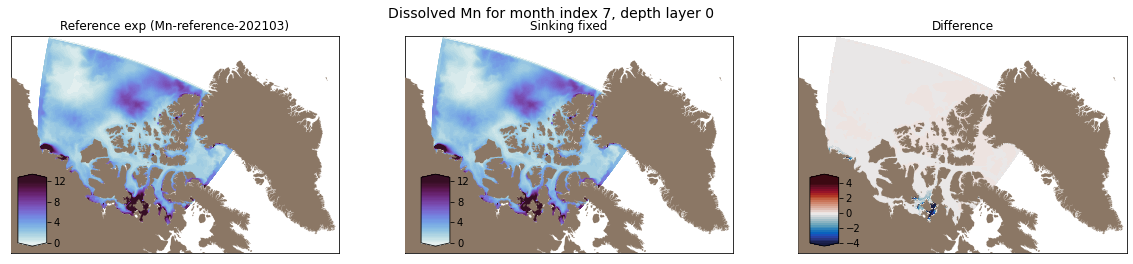

In [11]:
plot_comparison(dmn_spinup0_old, dmn_spinup0_new, month=7,layer=0)

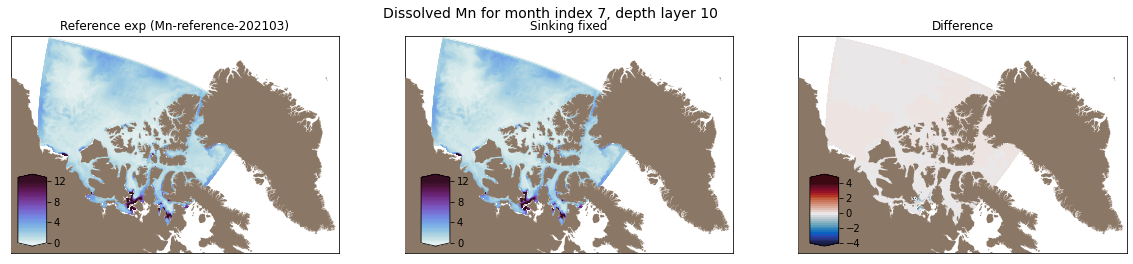

In [12]:
plot_comparison(dmn_spinup0_old, dmn_spinup0_new, month=7,layer=10)

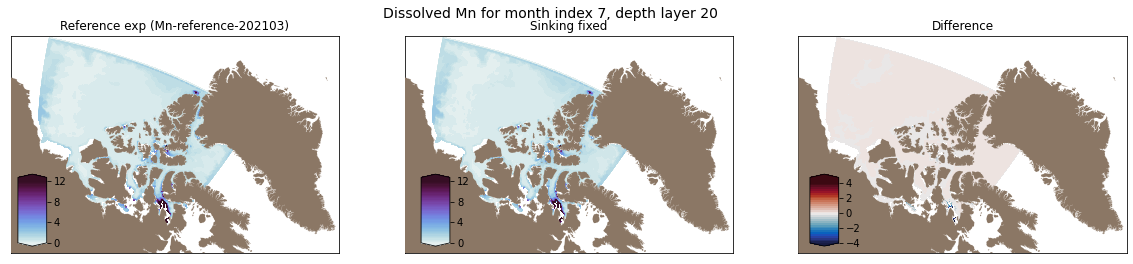

In [13]:
plot_comparison(dmn_spinup0_old, dmn_spinup0_new, month=7,layer=20)

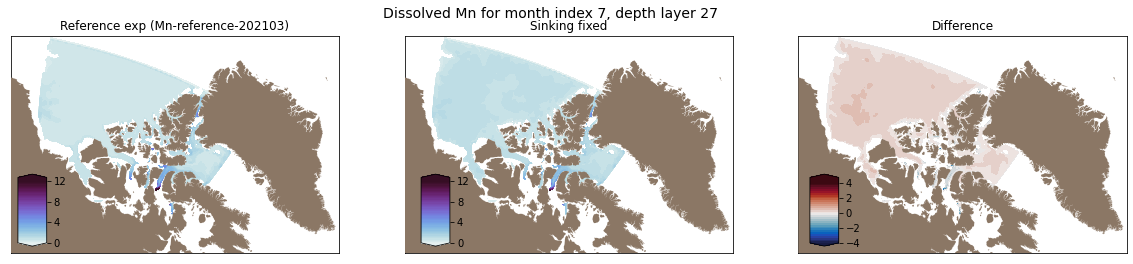

In [14]:
plot_comparison(dmn_spinup0_old, dmn_spinup0_new, month=7,layer=27)

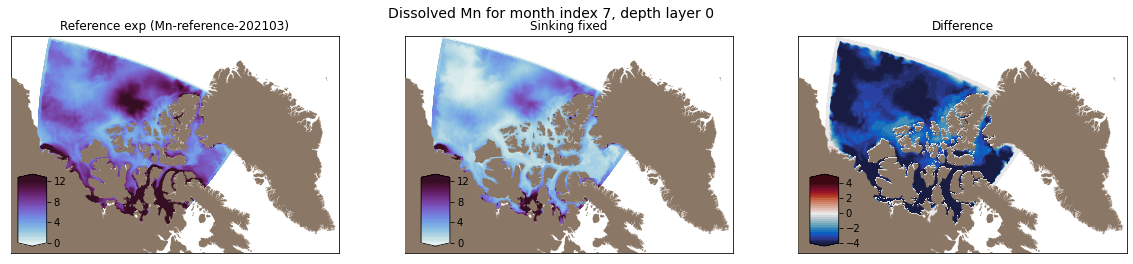

In [41]:
plot_comparison(dmn_spinup2_old, dmn_spinup2_new, month=7,layer=0)

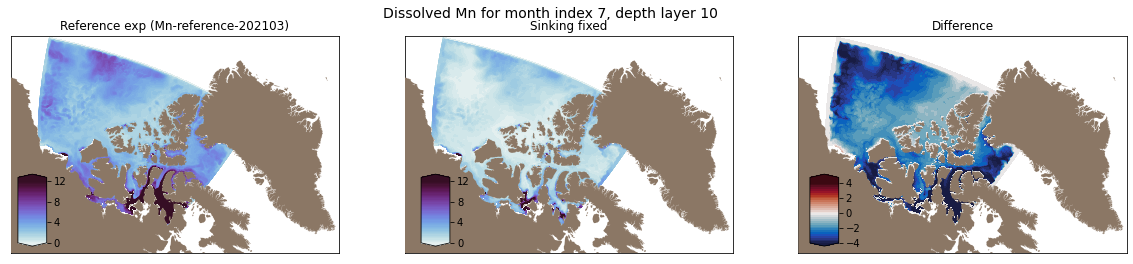

In [42]:
plot_comparison(dmn_spinup2_old, dmn_spinup2_new, month=7,layer=10)

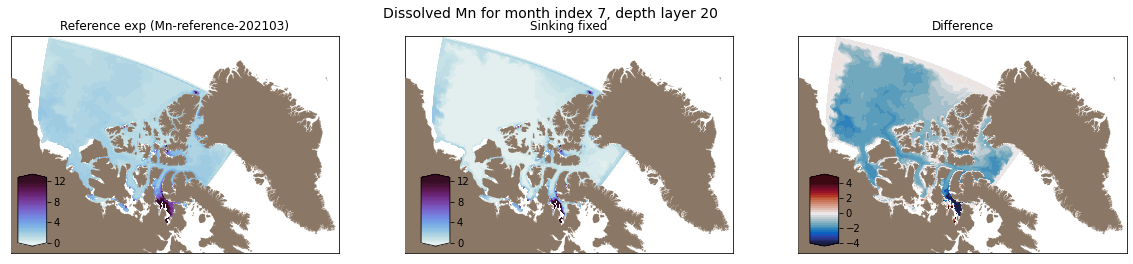

In [43]:
plot_comparison(dmn_spinup2_old, dmn_spinup2_new, month=7,layer=20)

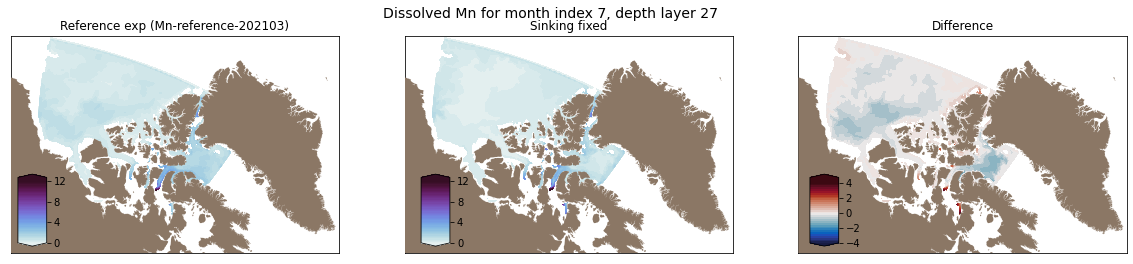

In [44]:
plot_comparison(dmn_spinup2_old, dmn_spinup2_new, month=7,layer=27)

Looking at the winter, it seems like the boundary concentrations are too high for the new experiment; will need to replace.

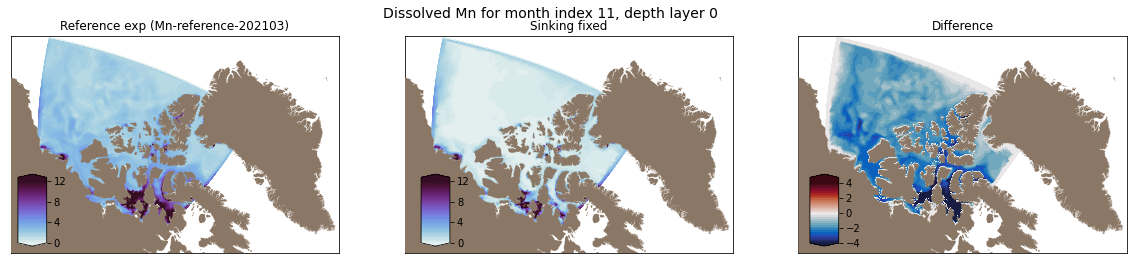

In [45]:
plot_comparison(dmn_spinup0_old, dmn_spinup0_new, month=11,layer=0)

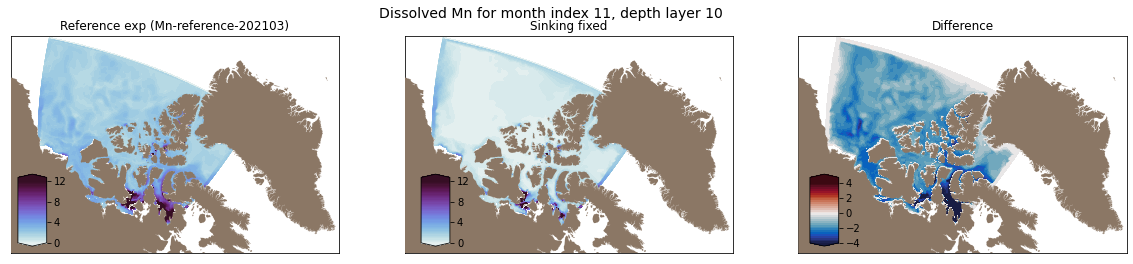

In [46]:
plot_comparison(dmn_spinup0_old, dmn_spinup0_new, month=11,layer=10)

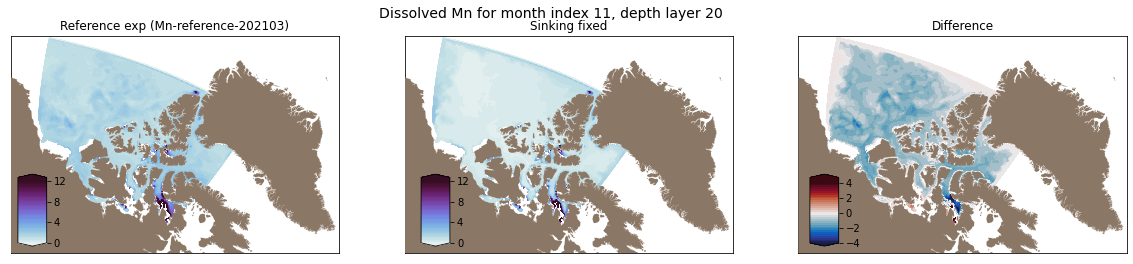

In [47]:
plot_comparison(dmn_spinup0_old, dmn_spinup0_new, month=11,layer=20)

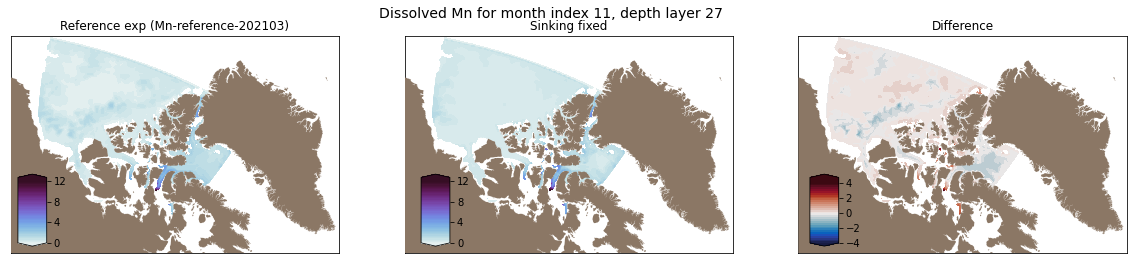

In [48]:
plot_comparison(dmn_spinup0_old, dmn_spinup0_new, month=11,layer=27)

### oxidised Mn concentrations:

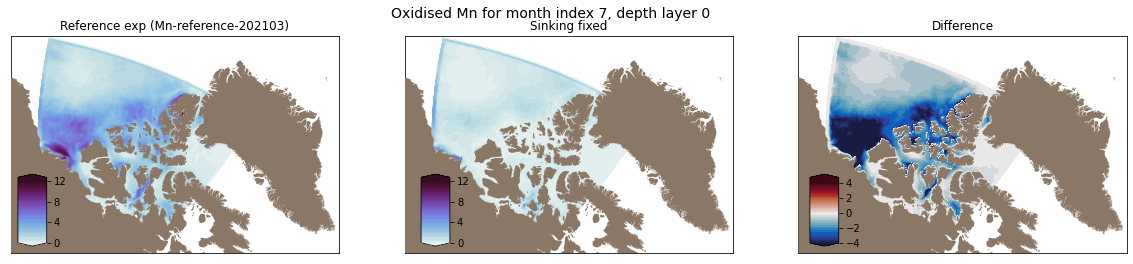

In [49]:
plot_comparison(omn_spinup0_old, omn_spinup0_new, month=7,layer=0, ox=True)

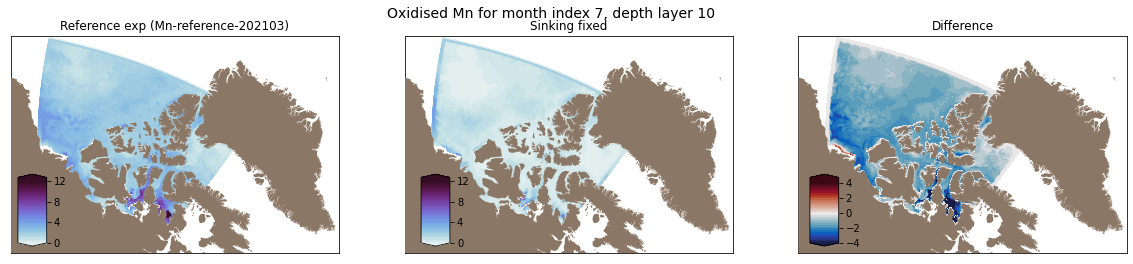

In [50]:
plot_comparison(omn_spinup0_old, omn_spinup0_new, month=7,layer=10, ox=True)

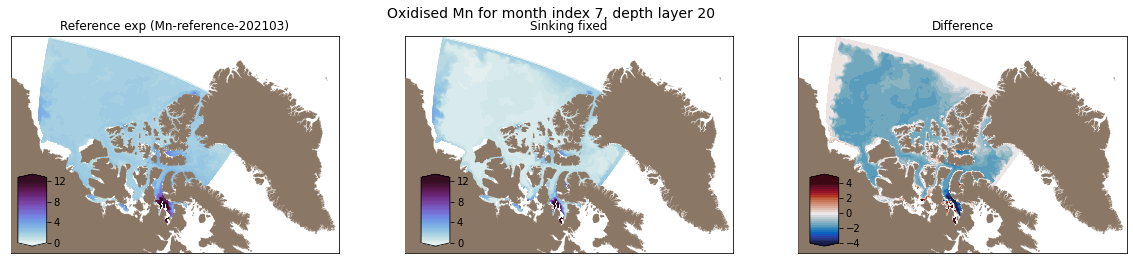

In [51]:
plot_comparison(omn_spinup0_old, omn_spinup0_new, month=7,layer=20, ox=True)

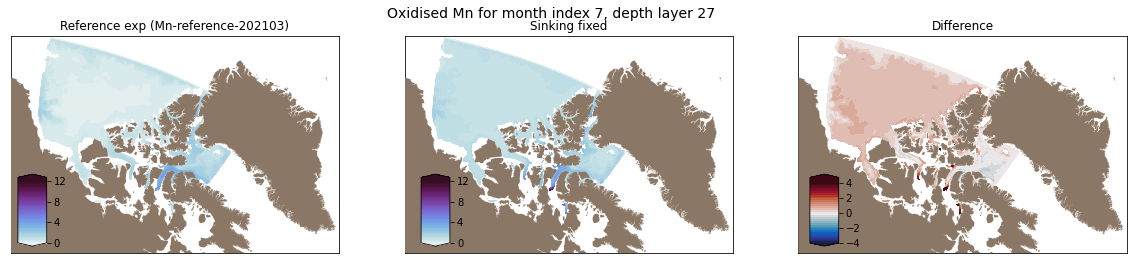

In [52]:
plot_comparison(omn_spinup0_old, omn_spinup0_new, month=7,layer=27, ox=True)

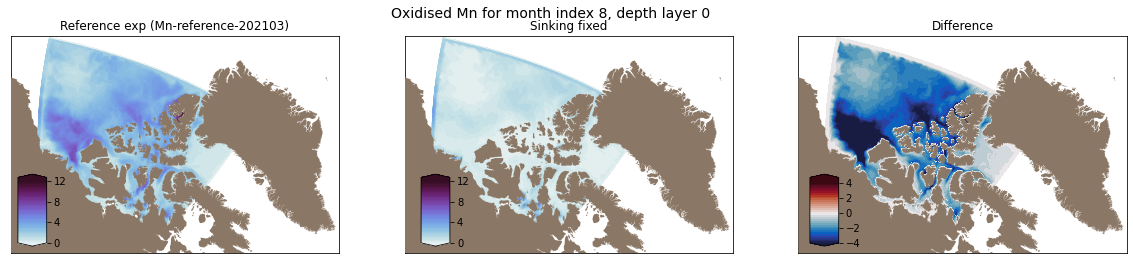

In [53]:
plot_comparison(omn_spinup0_old, omn_spinup0_new, month=8,layer=0, ox=True)

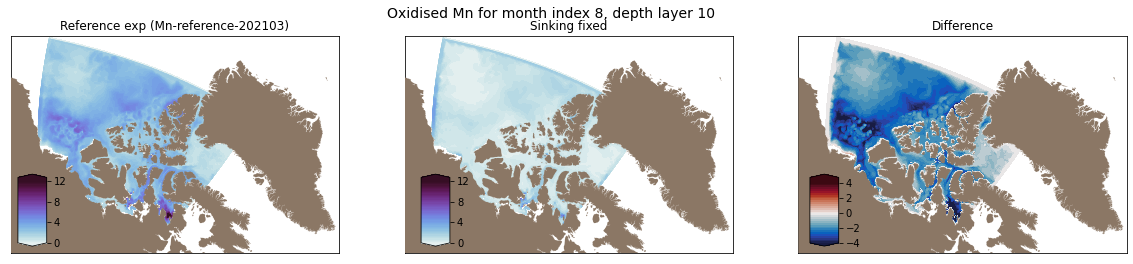

In [54]:
plot_comparison(omn_spinup0_old, omn_spinup0_new, month=8,layer=10, ox=True)

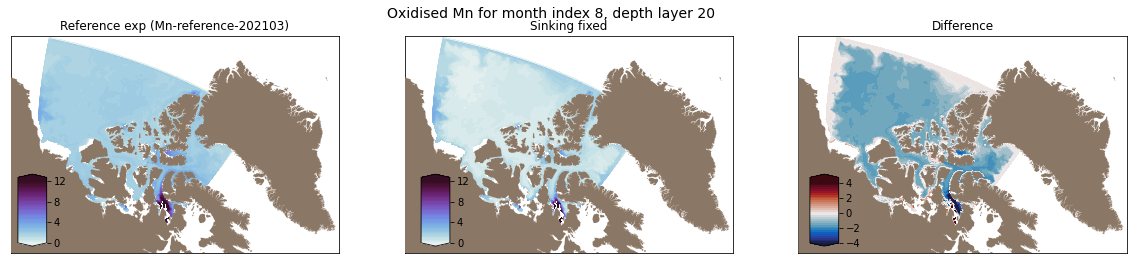

In [55]:
plot_comparison(omn_spinup0_old, omn_spinup0_new, month=8,layer=20, ox=True)

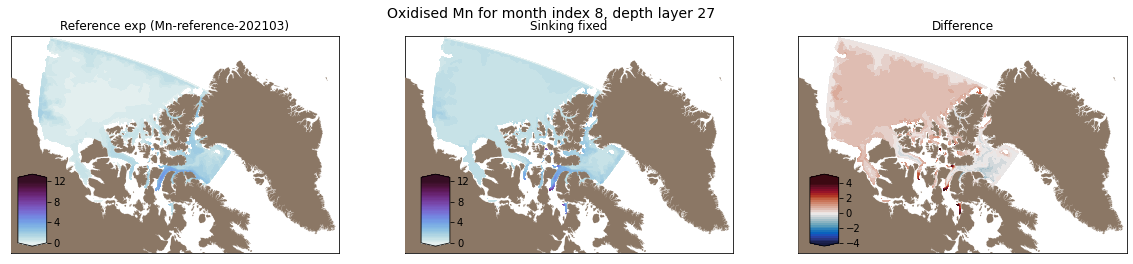

In [56]:
plot_comparison(omn_spinup0_old, omn_spinup0_new, month=8,layer=27, ox=True)

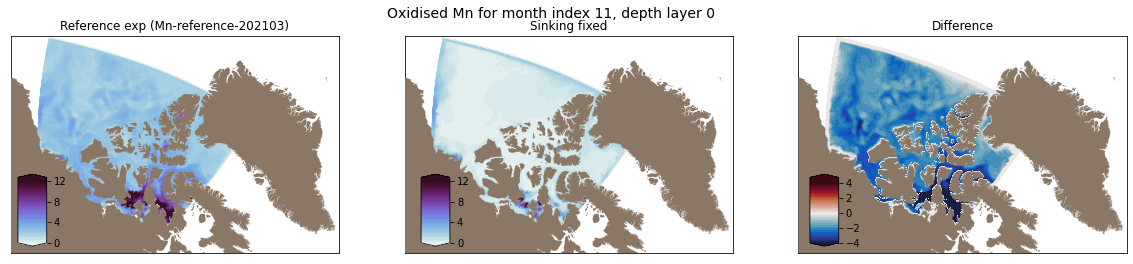

In [57]:
plot_comparison(omn_spinup0_old, omn_spinup0_new, month=11,layer=0, ox=True)

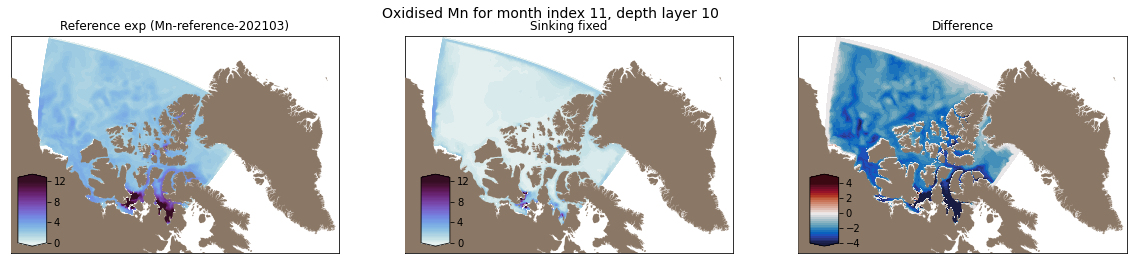

In [58]:
plot_comparison(omn_spinup0_old, omn_spinup0_new, month=11,layer=10, ox=True)

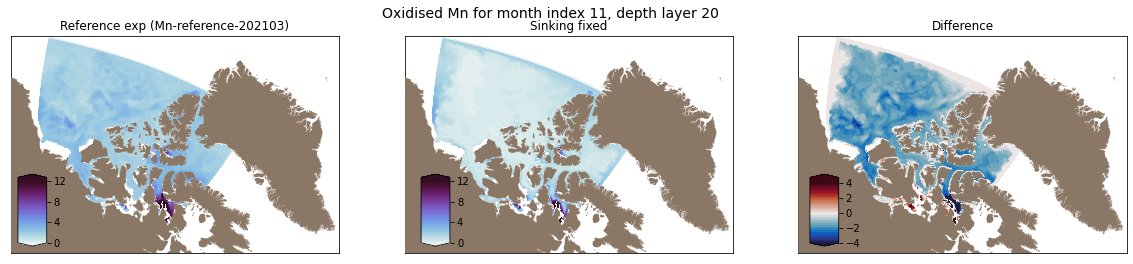

In [59]:
plot_comparison(omn_spinup0_old, omn_spinup0_new, month=11,layer=20, ox=True)

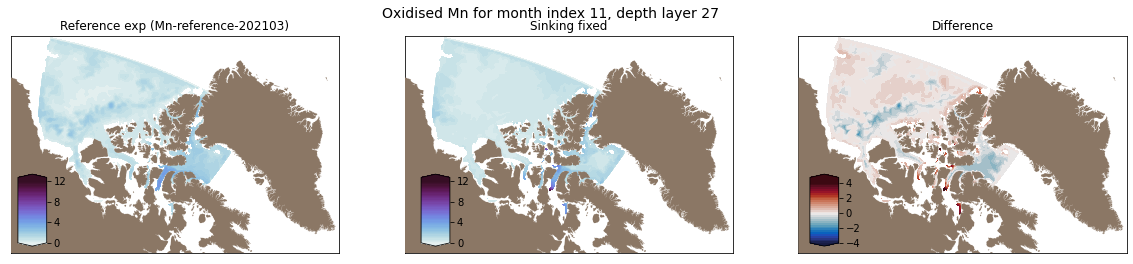

In [60]:
plot_comparison(omn_spinup0_old, omn_spinup0_new, month=11,layer=27, ox=True)